## PyTorch Convolutional Neural Network With MNIST Dataset

In [1]:
# --- pytorch utility imports
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.onnx
import onnx
import math
import functions

# --- neural net imports
import torch.nn as nn
import torch.nn.functional as Ft
import torch.optim as optim
from torch.autograd import Variable


In [2]:
# --- Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
# --- import external libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import math
from scipy import signal
from bitstring import Bits
import time


In [4]:
# --- Loading dataset
input_folder_path = "./data/"
train_df = pd.read_csv(input_folder_path+"train_0159_7_7.csv")
test_df = pd.read_csv(input_folder_path+"test.csv")


In [5]:
train_df

,label,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16794,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,178,0,0,0,0,0
16795,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
16796,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,81,0,0,0
16797,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test_df[0:1]

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train_df.shape

(16799, 101)

### Separate into labels and training images and reshape the images


In [8]:
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
test_images = (test_df.iloc[:,:].values).astype('float32')

# --- Training and Validation Split
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels,
                                                                      stratify=train_labels, random_state=123,
                                                                      test_size=0.20)


In [9]:
print("Train Shape: ",train_images.shape)
print("Test Shape : ",test_images.shape)
print("Val Shape  : ",val_images.shape)

Train Shape:  (13439, 100)
Test Shape :  (28000, 784)
Val Shape  :  (3360, 100)


In [10]:
train_images = train_images.reshape(train_images.shape[0], 10, 10)
val_images = val_images.reshape(val_images.shape[0], 10, 10)
test_images = test_images.reshape(test_images.shape[0], 28, 28)


In [11]:
print("Train Shape: ",train_images.shape)
print("Test Shape : ",test_images.shape)
print("Val Shape  : ",val_images.shape)

Train Shape:  (13439, 10, 10)
Test Shape :  (28000, 28, 28)
Val Shape  :  (3360, 10, 10)


## Plotting Images

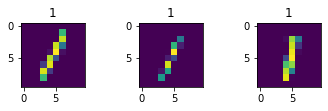

In [12]:
# --- train samples
for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(train_images[i])
    plt.title(train_labels[i])


In [13]:
# --- train
train_images_tensor = torch.from_numpy(train_images)/255.0
train_labels_tensor = torch.from_numpy(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

# --- val
val_images_tensor = torch.from_numpy(val_images)/255.0
val_labels_tensor = torch.from_numpy(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

# --- test
test_images_tensor = torch.from_numpy(test_images)/255.0


In [14]:
train_loader = DataLoader(train_tensor, batch_size=4, shuffle=True)
val_loader   = DataLoader(val_tensor, batch_size=4, shuffle=True)
test_loader  = DataLoader(test_images_tensor, batch_size=4, shuffle=False)


## Define the CNN Model


In [15]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        # --- Define Conv Part
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # --- Define Classification Part
        self.linear_block = nn.Sequential(
            nn.Linear(4*5*5, 4)
        )
        
    # --- Define forward
    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.linear_block(x)
        return x



In [16]:
conv_model = ConvNet()
conv_model

ConvNet(
  (conv_block): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=100, out_features=4, bias=True)
  )
)

## optimizer and loss functions

In [40]:
optimizer = optim.SGD(params=conv_model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

## Training the Model


In [35]:
# --- Training 
n_total_steps = len(train_loader)
num_epochs = 11
loss_list = []
for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        # --- make true data and target
        temp_target = target.numpy()
        result_target = []
        for i in temp_target:
            if i == 0:
                result_target.append(0)
            elif i == 1:
                result_target.append(1)
            elif i == 5:
                result_target.append(2)
            elif i == 9:
                result_target.append(3)
                
        target = torch.tensor(result_target)
        data = data.unsqueeze(1)
        
        # --- forward
        output = conv_model(data)
        loss = criterion(output, target)
        
        # --- backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # --- some Info
    if epoch%2 == 0:
        print(f'epoch {epoch+1} / {num_epochs}, loss = {loss.item():.4f}')
    loss_list.append(loss.item())


epoch 1 / 11, loss = 1.2799
epoch 3 / 11, loss = 0.9152
epoch 5 / 11, loss = 0.6998
epoch 7 / 11, loss = 0.1736
epoch 9 / 11, loss = 0.4332
epoch 11 / 11, loss = 0.1933


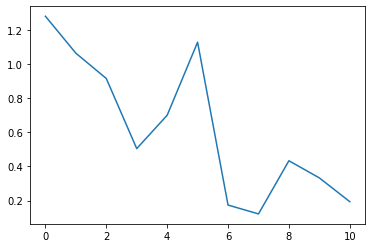

In [36]:
# --- Plot Loss 
x = range(num_epochs)
plt.plot(x, loss_list)
plt.show()

In [13]:
# --- save the model
# torch.save(conv_model.state_dict(), "./models/model.pt")

# --- load the model
conv_model.load_state_dict(torch.load("./models/model.pt"))
conv_model.eval()


ConvNet(
  (conv_block): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_block): Sequential(
    (0): Linear(in_features=100, out_features=4, bias=True)
  )
)

## Evaluate CNN model

In [18]:
conv_model.eval()
loss = 0
correct = 0

with torch.no_grad():
    for data, target in val_loader:
        
        # --- make true data and target
        temp_target = target.numpy()
        result_target = []
        for i in temp_target:
            if i == 0:
                result_target.append(0)
            elif i == 1:
                result_target.append(1)
            elif i == 5:
                result_target.append(2)
            elif i == 9:
                result_target.append(3)
                
        target = torch.tensor(result_target)
        data = data.unsqueeze(1)
        output = conv_model(data)

        loss += F.cross_entropy(output, target, size_average=False).item()

        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    loss /= len(val_loader.dataset)

    print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))


Average Val Loss: 0.2602, Val Accuracy: 3140/3360 (93.452%)



## Test Dataset and Visualization

Orginal value   :  5
Presicted value :  0


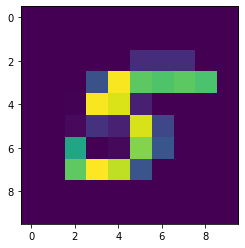

In [19]:
idx = 29
# --- plot image
test_image = val_images[idx].astype(np.uint8)
plt.imshow(test_image)

# --- show orginal value
print("Orginal value   : ", val_labels[idx])

# --- show predicted value
with torch.no_grad():
    tensor_image = torch.from_numpy(val_images[idx])
    tensor_image = tensor_image.unsqueeze(0)
    tensor_image = tensor_image.unsqueeze(0)
    predicted_value = conv_model(tensor_image).numpy()
    predicted_value = np.argmax(predicted_value)
    if predicted_value == 2:
        predicted_value = 5
    elif predicted_value == 3:
        predicted_value = 9
    print("Presicted value : ", predicted_value)    
            
        

In [ ]:
with torch.no_grad():
    for idx in range(len(val_labels)):
        test_image = val_images[idx].astype(np.uint8)

        tensor_image = torch.from_numpy(val_images[idx])
        tensor_image = tensor_image.unsqueeze(0)
        tensor_image = tensor_image.unsqueeze(0)
        predicted_value = conv_model(tensor_image).numpy()
        predicted_value = np.argmax(predicted_value)
        if predicted_value == 2:
            predicted_value = 5
        elif predicted_value == 3:
            predicted_value = 9

        if val_labels[idx] != predicted_value:
            print(idx)
            

## ONNX Export


In [46]:
# --- Export the model
x = torch.randn(4, 1, 10, 10, requires_grad=True)

torch.onnx.export(conv_model,                # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "./models/model.onnx",     # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  input_names = ['input'],   # the model's input names
                  output_names = ['output']  # the model's output names
                 )


In [4]:
# --- load and check
onnx_model = onnx.load("./models/model.onnx")
onnx.checker.check_model(onnx_model)


In [5]:
from onnx import numpy_helper
INTIALIZERS  = onnx_model.graph.initializer
nodes=onnx_model.graph.node
onnx_weights = {}
for initializer in INTIALIZERS:
    W = numpy_helper.to_array(initializer)
    onnx_weights[initializer.name] = W

In [6]:
print(onnx_weights.keys())
ky=list(onnx_weights.keys())


dict_keys(['conv_block.0.weight', 'conv_block.0.bias', 'linear_block.0.weight', 'linear_block.0.bias', '17'])


In [17]:
conv_w_1 = onnx_weights['conv_block.0.weight'][0][0]
print(conv_w_1)

[[-0.08283696 -0.3559535  -0.13986284]
 [ 0.04469441 -0.42447752 -0.66592926]
 [ 0.3191516   0.64586574  0.88528347]]


In [18]:
conv_w_2 = onnx_weights['conv_block.0.weight'][1][0]
print(conv_w_2)

[[ 0.34157342 -0.25934675  0.11585948]
 [-0.12829612  0.0625388  -0.05002215]
 [-0.21764195  0.19251591 -0.26899686]]


In [19]:
conv_w_3 = onnx_weights['conv_block.0.weight'][2][0]
print(conv_w_3)

[[-0.20927872 -0.1884275   0.15589876]
 [-0.1748103  -0.05102624  0.21250954]
 [-0.13811535 -0.31749466 -0.05603961]]


In [20]:
conv_w_4 = onnx_weights['conv_block.0.weight'][3][0]
print(conv_w_4)

[[ 0.61532557  1.3386121   0.31283677]
 [ 1.0323175   1.2751912  -0.31333235]
 [ 1.4164771   0.20937458  0.11632154]]


In [21]:
conv_b = onnx_weights['conv_block.0.bias']
print(conv_b)

[ 5.2623779e-01 -2.5713012e-01  2.0757751e-01  4.5666384e-04]


In [9]:
conv_b = onnx_weights['linear_block.0.bias']
print(np.round(conv_b*64))

[-18.  18.   0.  -6.]


In [22]:
print(np.max(abs(onnx_weights['linear_block.0.weight'][0])))
print(np.max(abs(onnx_weights['linear_block.0.weight'][1])))
print(np.max(abs(onnx_weights['linear_block.0.weight'][2])))
print(np.max(abs(onnx_weights['linear_block.0.weight'][3])))                                                                                   

0.7030218
1.0476896
0.6279603
0.7843218


## Quantizing 

In [28]:
# ---------- Quntizing Conv layer ---------
# --- Conv weights --> (S.1.6)
# --- Conv biases  --> (S.0.7)
# --- input        --> (S.0.7)
# --- W*I          --> (S.5.13)
# --- W*I + b      --> (S.6.7)  

# ---------- Quantizing Classifiation Layer ------------

In [24]:
qconv_w_1 = np.round(conv_w_1*64) 
print(qconv_w_1)

[[ -5. -23.  -9.]
 [  3. -27. -43.]
 [ 20.  41.  57.]]


In [25]:
qconv_w_2 = np.round(conv_w_2*64) 
print(qconv_w_2)

[[ 22. -17.   7.]
 [ -8.   4.  -3.]
 [-14.  12. -17.]]


In [26]:
qconv_w_3 = np.round(conv_w_3*64) 
print(qconv_w_3)

[[-13. -12.  10.]
 [-11.  -3.  14.]
 [ -9. -20.  -4.]]


In [27]:
qconv_w_4 = np.round(conv_w_4*64) 
print(qconv_w_4)

[[ 39.  86.  20.]
 [ 66.  82. -20.]
 [ 91.  13.   7.]]


In [28]:
qconv_b = np.round(conv_b*128) 
print(qconv_b)

[ 67. -33.  27.   0.]


In [18]:
# --- Quantizing Classificatin Weights
qclass_w_1 = np.round(onnx_weights['linear_block.0.weight'][0] * 64)
qclass_w_2 = np.round(onnx_weights['linear_block.0.weight'][1] * 64)
qclass_w_3 = np.round(onnx_weights['linear_block.0.weight'][2] * 64)
qclass_w_4 = np.round(onnx_weights['linear_block.0.weight'][3] * 64)


In [21]:
# --- Make binary of concatenated data to write them in BRAM file
qclass_w = []
for i in range(0,25):
    temp =  Bits(int=int(qclass_w_1[i]),length=8).bin    + \
            Bits(int=int(qclass_w_2[i]),length=8).bin    + \
            Bits(int=int(qclass_w_3[i]),length=8).bin    + \
            Bits(int=int(qclass_w_4[i]),length=8).bin    + \
            Bits(int=int(qclass_w_1[i+25]),length=8).bin + \
            Bits(int=int(qclass_w_2[i+25]),length=8).bin + \
            Bits(int=int(qclass_w_3[i+25]),length=8).bin + \
            Bits(int=int(qclass_w_4[i+25]),length=8).bin + \
            Bits(int=int(qclass_w_1[i+50]),length=8).bin + \
            Bits(int=int(qclass_w_2[i+50]),length=8).bin + \
            Bits(int=int(qclass_w_3[i+50]),length=8).bin + \
            Bits(int=int(qclass_w_4[i+50]),length=8).bin + \
            Bits(int=int(qclass_w_1[i+75]),length=8).bin + \
            Bits(int=int(qclass_w_2[i+75]),length=8).bin + \
            Bits(int=int(qclass_w_3[i+75]),length=8).bin + \
            Bits(int=int(qclass_w_4[i+75]),length=8).bin
    qclass_w.append(temp)

In [23]:
np.round((onnx_weights['linear_block.0.weight'][0][0])* 64)

-3.0

In [29]:
onnx_weights['linear_block.0.weight'][0][0]

-0.04208606

In [21]:
-384/8192

-0.046875

In [69]:
# --- Insert data in .COE BRAM initialization file
f = open("./inc/class_BRAM.coe", "w")
f.write('memory_initialization_radix = 2;')
f.write("\n")
f.write('memory_initialization_vector =')
f.write("\n")
for index,data in enumerate(qclass_w):
    f.write(data)
    if index == len(qclass_w)-1:
        f.write(';')
    else:
        f.write(',')
    f.write("\n")
        
f.close()

## Test An Image

In [23]:
train_images.shape

(13439, 10, 10)

In [31]:
test_image = train_images[0]
test_tensor = torch.from_numpy(test_image/255)
test_tensor = test_tensor.unsqueeze(0)
test_tensor = test_tensor.unsqueeze(0)
test_tensor.shape
print("Orginal Value is: ", train_labels[0])
print("Predicted Value is: ",conv_model(test_tensor))

Orginal Value is:  1
Predicted Value is:  tensor([[-2.9169,  3.6037,  0.1704, -0.2773]], grad_fn=<AddmmBackward>)


In [18]:
test_image = train_images[500]
test_tensor = torch.from_numpy(test_image/255)
test_tensor = test_tensor.unsqueeze(0)
test_tensor = test_tensor.unsqueeze(0)
test_tensor.shape
print("Orginal Value is: ", train_labels[0])
print("Predicted Value is: ",conv_model(test_tensor))

Orginal Value is:  1
Predicted Value is:  tensor([[ 3.5500, -2.6531,  1.3534, -1.3254]], grad_fn=<AddmmBackward>)


In [21]:
np.round(np.array([ 3.5500, -2.6531,  1.3534, -1.3254]) * 64)

array([ 227., -170.,   87.,  -85.])

In [13]:
(np.array([231, -169, 81, -85]) / 64) - np.array([ 3.5500, -2.6531,  1.3534, -1.3254])

array([ 0.059375,  0.012475, -0.087775, -0.002725])

In [24]:
np.array([ 3.890625, -2.921875,  1.265625, -1.234375]) + onnx_weights['linear_block.0.bias']

array([ 3.60492024, -2.64144668,  1.26697331, -1.32941756])

In [11]:
onnx_weights['linear_block.0.bias']*64

array([-18.285105  ,  17.947412  ,   0.08629173,  -6.0827236 ],
      dtype=float32)

In [53]:
# --- 1.31 us
# --- 996  us

In [32]:
test_image

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   4., 165.,   3.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 145., 251.,  56.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 225., 253.,   4.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 248., 242.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   6., 251., 223.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   9., 251., 223.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   1., 251., 248.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 150., 163.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]],
      dtype=float32)

In [19]:
test_image

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 242., 233., 234.,   2.,   0.,   0.],
       [  0.,   0.,   0.,  28., 247.,   0.,   7., 116.,   0.,   0.],
       [  0.,   0.,   0., 118.,   0.,   0.,   0., 186.,   0.,   0.],
       [  0.,   0.,   0., 230.,   0.,   0.,   0., 193.,   0.,   0.],
       [  0.,   0.,   0., 215.,   0.,   0.,   0., 140.,   0.,   0.],
       [  0.,   0.,   0., 206.,   0.,   0.,  63.,  72.,   0.,   0.],
       [  0.,   0.,   0., 169.,  75., 128., 168.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]],
      dtype=float32)

In [32]:
np.ceil((test_image/255)*128)

array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   3.,  83.,   2.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  73., 126.,  29.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 113., 127.,   3.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0., 125., 122.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   4., 126., 112.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   5., 126., 112.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   1., 126., 125.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,  76.,  82.,   0.,   0.,   0.,   0.],
       [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.]],
      dtype=float32)

In [86]:
# --- Make an stream data from normalized image
f = open("./inc/image_stream.txt", "w")
for i in test_image:
    for j in i:
        if j == 255:
            j = 254
        j = math.ceil(j/255 * 128)
        f.write(str(j))
        f.write("\n")

for i in range(17):
    f.write(str(0))
    f.write("\n")
        
f.close()


In [20]:
# --- Make an stream data from normalized image
f = open("./inc/image_stream2.txt", "w")
for i in test_image:
    for j in i:
        if j == 255:
            j = 254
        j = math.ceil(j/255 * 128)
        f.write(str(j))
        f.write("\n")

for i in range(17):
    f.write(str(0))
    f.write("\n")
        
f.close()

In [114]:
# --- recover stream result from FPGA
file1 = open('./inc/result_conv.txt', 'r')
Lines = file1.readlines()

data = []
for index,line in enumerate(Lines):
    if index>=19 and index<119:
        data.append(int(line))

file1.close()
data = np.array(data)
data = data.reshape(10,10)
print(data)

[[ 67  67  67  69 142 122  94  67  67  67]
 [ 67  67  67 130 168 160 128  76  67  67]
 [ 67  67  67 118 124  86  95  69  67  67]
 [ 67  67  67  92  78  78  89  64  67  67]
 [ 67  67  70  81  55  77  96  66  67  67]
 [ 67  67  68  78  58  83  97  67  67  67]
 [ 67  67  63  73  69  95 102  67  67  67]
 [ 67  67  65  30 -10  46  89  67  67  67]
 [ 67  67  66  -3 -84 -19  61  67  67  67]
 [ 67  67  67  56  28  31  60  67  67  67]]


In [43]:
conved = functions.convolution2d(test_image/255, conv_w_3, 1, 1) + conv_b[2]
print(np.ceil(conved*128))

[[  27.   27.   27.   27.   22.   -0.   15.   27.   27.   27.]
 [  27.   27.   27.   23.   14.  -29.  -14.   23.   27.   27.]
 [  27.   27.   27.   37.   20.  -58.  -32.   22.   27.   27.]
 [  27.   27.   27.   55.    8.  -89.  -44.   21.   27.   27.]
 [  27.   27.   27.   63.   -2. -101.  -37.   27.   27.   27.]
 [  27.   27.   27.   65.   -8. -103.  -33.   27.   27.   27.]
 [  27.   27.   28.   65.  -10. -105.  -33.   27.   27.   27.]
 [  27.   27.   28.   68.   11.  -85.  -29.   27.   27.   27.]
 [  27.   27.   27.   63.   36.  -40.  -13.   27.   27.   27.]
 [  27.   27.   27.   39.   26.   -4.   10.   27.   27.   27.]]


In [38]:
conv_b[1] * 128

-32.912654876708984

In [41]:
conv_b[2] * 128

26.569921493530273